# Синтез изображений. Часть 2. Генеративно-Состязательная Сеть (GAN)

## Переключение версии TensorFlow

In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import numpy as np  # Импортируем библиотеку NumPy для работы с многомерными массивами и математическими операциями
import matplotlib.pyplot as plt  # Импортируем библиотеку Matplotlib для визуализации данных и изображений

import tensorflow as tf  # Импортируем TensorFlow — библиотеку для машинного обучения и создания нейронных сетей


## Загрузка и подготовка датасета MNIST

In [0]:
# Загружаем датасет MNIST из встроенных данных TensorFlow
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()
# train_x — обучающие изображения (28x28 пикселей)
# train_y — метки к обучающим изображениям (числа от 0 до 9)
# test_x, test_y — аналогично, для тестовой выборки

# Преобразуем обучающие изображения:
train_x = (train_x.reshape(-1, 28*28).astype(np.float32) - 127.5) / 127.5
# .reshape(-1, 28*28): меняем форму массива из (число_изображений, 28, 28) в (число_изображений, 784)
# Это преобразует каждое изображение в вектор из 784 пикселей (28*28=784)
# .astype(np.float32): преобразуем тип данных из целочисленного (int) в число с плавающей точкой (float32)
# Вычитаем 127.5 и делим на 127.5 — нормализация данных:
# - Значения пикселей из диапазона [0,255] переводятся в диапазон [-1,1]
# - Это важно для стабильного обучения нейросети

# Выводим размерность и тип данных обучающего массива
print(train_x.shape, train_x.dtype)
# Например, (60000, 784) float32 — 60000 изображений, каждое вектор размером 784

# Выводим минимальное и максимальное значение пикселей после нормализации
print(np.min(train_x), np.max(train_x))
# Ожидается примерно -1.0 и 1.0, что подтверждает правильную нормализацию

11493376/11490434 [==============================] - 0s 0us/step
(60000, 784) float32
-1.0 1.0


## Визуализация датасета MNIST

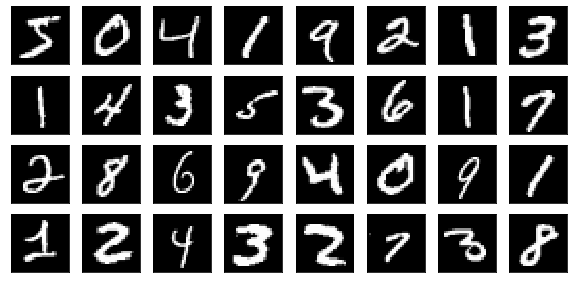

In [0]:
def plot_digits(samples):
    fig = plt.figure(figsize=(10, 10))
    # Создаем пустую фигуру для отображения изображений, размер 10x10 дюймов

    num = samples.shape[0]
    # Получаем количество изображений в samples (число строк в массиве)

    for j in range(num):
        ax = fig.add_subplot(8, 8, j+1)
        # Создаем сетку из 8 строк и 8 столбцов для подграфиков (до 64 изображений)
        # j+1 - номер текущего подграфика (нумерация с 1)

        ax.imshow(samples[j, ...].reshape(28, 28), cmap='gray')
        # Отображаем j-е изображение, преобразованное из вектора обратно в форму 28x28
        # cmap='gray' - отображаем в градациях серого (черно-белое изображение)

        plt.xticks([]), plt.yticks([])
        # Убираем подписи осей (тиков) по x и y для чистоты визуализации

    plt.show()
    # Показываем всю фигуру с сеткой изображений

plot_digits(train_x[:32, ...])
# Вызываем функцию для первых 32 изображений из train_x
# train_x хранит изображения в нормализованном виде, но для отображения важно только правильное reshape


## Создание Генератора и Дискриминатора

In [0]:
# Создаем генератор — нейронную сеть, которая будет создавать "фейковые" изображения из случайного шума
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(256),
    # Полносвязный (Dense) слой с 256 нейронами. Принимает вход и вычисляет 256 признаков.

    tf.keras.layers.LeakyReLU(0.2),
    # Активационная функция LeakyReLU с коэффициентом 0.2. Позволяет небольшое отрицательное значение при входе < 0, чтобы избежать "мертвых нейронов".

    tf.keras.layers.BatchNormalization(momentum=0.8),
    # Нормализация батчей с параметром momentum=0.8 — помогает стабилизировать и ускорить обучение.

    tf.keras.layers.Dense(512),
    # Еще один Dense слой с 512 нейронами, увеличиваем размерность признаков.

    tf.keras.layers.LeakyReLU(0.2),
    # Снова LeakyReLU для нелинейности.

    tf.keras.layers.BatchNormalization(momentum=0.8),
    # Нормализация.

    tf.keras.layers.Dense(1024),
    # Dense слой с 1024 нейронами — еще больше признаков.

    tf.keras.layers.LeakyReLU(0.2),
    # LeakyReLU.

    tf.keras.layers.BatchNormalization(momentum=0.8),
    # Нормализация.

    tf.keras.layers.Dense(784, activation='tanh'),
    # Выходной Dense слой с 784 нейронами — размерностью изображения 28x28 пикселей,
    # активация tanh, чтобы выходные значения были в диапазоне [-1, 1], как нормализованные пиксели.
])

# Создаем дискриминатор — сеть, которая будет определять, настоящее ли изображение или сгенерированное
discriminator = tf.keras.Sequential([
    tf.keras.layers.Dense(784),
    # Входной слой, принимающий изображение размером 784 (28x28 пикселей, развернутых в вектор).

    tf.keras.layers.LeakyReLU(alpha=0.2),
    # LeakyReLU с параметром alpha=0.2 для активации.

    tf.keras.layers.Dense(392),
    # Следующий Dense слой с 392 нейронами (половина от 784).

    tf.keras.layers.LeakyReLU(alpha=0.2),
    # LeakyReLU.
    tf.keras.layers.Flatten(),           # Преобразуем 4D тензор в 2D (batch_size, features)
    tf.keras.layers.Dense(1),
    # Выходной слой с одним нейроном — выдаёт одно число, которое интерпретируется как вероятность того, что изображение настоящее (обычно с активацией sigmoid на этапе обучения).
])


## Подготовка пайплайна данных и оптимизатора

In [0]:
INPUT_DIM = 100
# Размер входного шума для генератора — длина вектора случайных чисел (обычно 100)

NUM_EPOCHS = 5
# Количество эпох — сколько раз модель пройдет по всему набору данных

HALF_BATCH_SIZE = 16
# Половина размера батча — используется для обучения отдельно генератора и дискриминатора
# Например, дискриминатор обучается на реальных и фейковых изображениях по 16 штук

BATCH_SIZE = HALF_BATCH_SIZE * 2
# Полный размер батча — сумма двух половин (32), это общее количество примеров за один шаг обучения

LEARNING_RATE = 0.0002
# Скорость обучения для оптимизатора — определяет размер шага обновления весов сети

# Создаем датасет из массива train_x (обучающих изображений)
train_ds = tf.data.Dataset.from_tensor_slices(train_x)
# from_tensor_slices — разбивает массив на отдельные элементы (каждое изображение)

train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])
# Перемешиваем данные с размером буфера равным количеству изображений (чтобы перемешивание было полным)

train_ds = train_ds.repeat(NUM_EPOCHS)
# Повторяем датасет нужное число эпох (5 раз), чтобы пройти по данным несколько раз

train_ds = train_ds.batch(HALF_BATCH_SIZE, drop_remainder=True)
# Разбиваем данные на батчи по 16 изображений
# drop_remainder=True означает, что последний неполный батч будет отброшен, чтобы всегда иметь одинаковый размер батча

# Создаем оптимизатор Adam с заданной скоростью обучения
# Инициализируем переменные моделей, чтобы оптимизатор увидел их
# Инициализация моделей (создаем переменные)
_ = generator(np.random.normal(0, 1, (1, INPUT_DIM)).astype(np.float32))
_ = discriminator(np.random.normal(0, 1, (1, 28, 28, 1)).astype(np.float32))
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
# Adam — популярный оптимизатор, адаптирующий скорость обучения для каждого параметра

# Определяем функцию потерь для бинарной классификации с логитами
sigmoid_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# BinaryCrossentropy — кросс-энтропия для двух классов (реальное/фейковое)
# from_logits=True указывает, что входные значения (выходы сети) не проходят через sigmoid,
# поэтому функция сама применит sigmoid внутри для вычисления потерь

## Обучение GAN

[Step  0] D Loss: 0.7935; G Loss: 0.7868


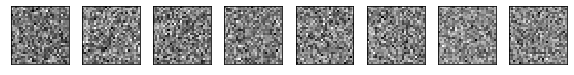

[Step 500] D Loss: 0.1922; G Loss: 10.1456


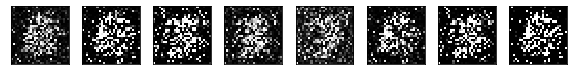

[Step 1000] D Loss: 0.4871; G Loss: 1.6506


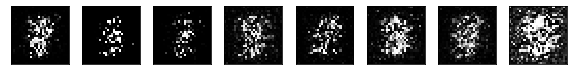

[Step 1500] D Loss: 0.3655; G Loss: 2.1592


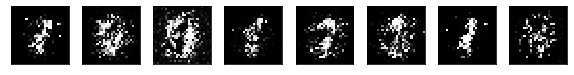

[Step 2000] D Loss: 0.2607; G Loss: 1.8468


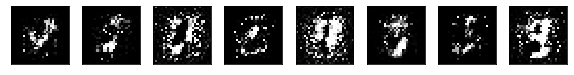

[Step 2500] D Loss: 0.4843; G Loss: 1.5044


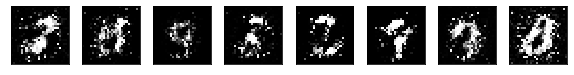

[Step 3000] D Loss: 0.3949; G Loss: 1.3675


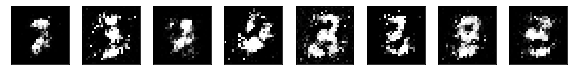

[Step 3500] D Loss: 0.6228; G Loss: 1.0760


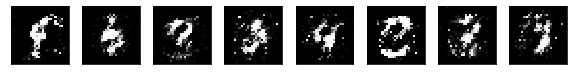

[Step 4000] D Loss: 0.6689; G Loss: 2.1625


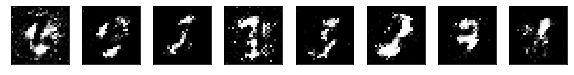

[Step 4500] D Loss: 0.4047; G Loss: 1.7198


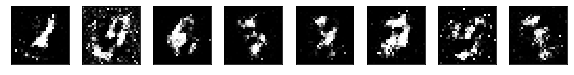

[Step 5000] D Loss: 0.4618; G Loss: 1.8384


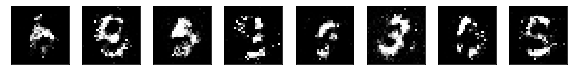

[Step 5500] D Loss: 0.5734; G Loss: 0.7546


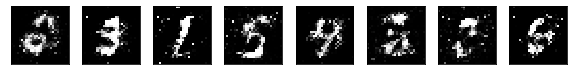

[Step 6000] D Loss: 0.4028; G Loss: 1.2002


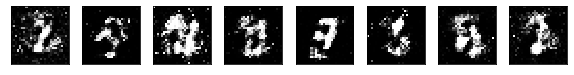

[Step 6500] D Loss: 0.5185; G Loss: 0.8117


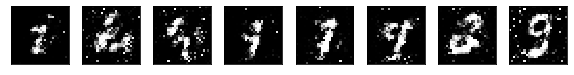

[Step 7000] D Loss: 0.5569; G Loss: 1.9346


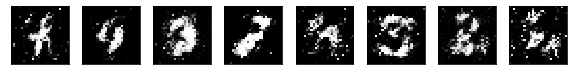

[Step 7500] D Loss: 0.4773; G Loss: 2.0228


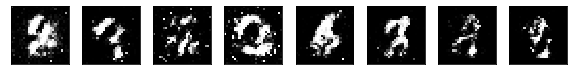

[Step 8000] D Loss: 0.4841; G Loss: 1.1538


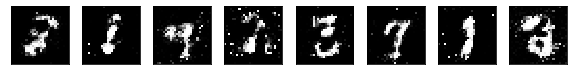

[Step 8500] D Loss: 0.5081; G Loss: 0.7136


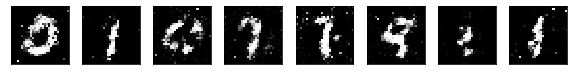

[Step 9000] D Loss: 0.4756; G Loss: 1.0888


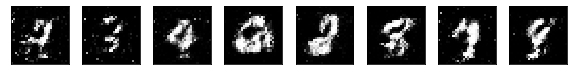

[Step 9500] D Loss: 0.4285; G Loss: 0.9998


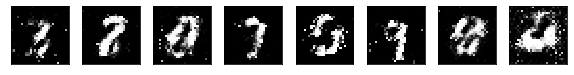

[Step 10000] D Loss: 0.4765; G Loss: 1.4216


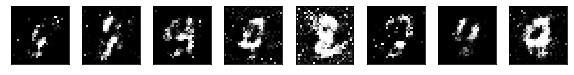

[Step 10500] D Loss: 0.4375; G Loss: 1.8597


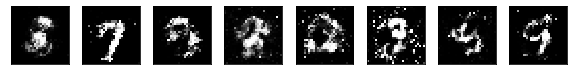

[Step 11000] D Loss: 0.6107; G Loss: 0.8571


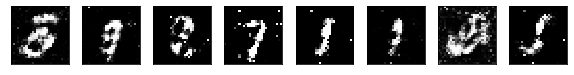

[Step 11500] D Loss: 0.7648; G Loss: 1.9589


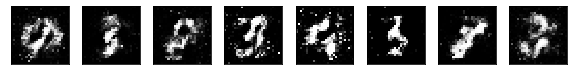

[Step 12000] D Loss: 0.4419; G Loss: 1.1365


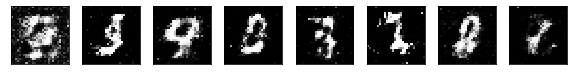

[Step 12500] D Loss: 0.3809; G Loss: 1.4182


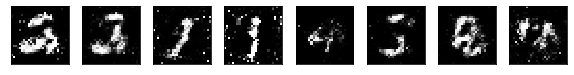

[Step 13000] D Loss: 0.7876; G Loss: 0.9623


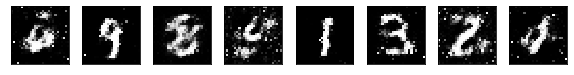

[Step 13500] D Loss: 0.4902; G Loss: 1.6556


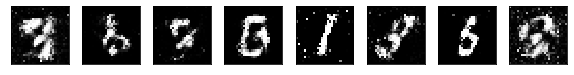

[Step 14000] D Loss: 0.6526; G Loss: 0.8868


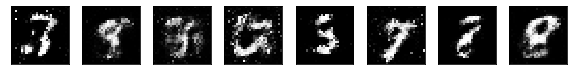

[Step 14500] D Loss: 0.6515; G Loss: 1.2701


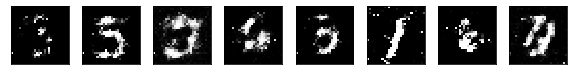

[Step 15000] D Loss: 0.3728; G Loss: 0.9267


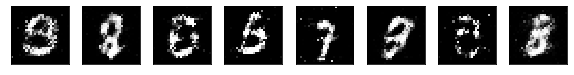

[Step 15500] D Loss: 0.5947; G Loss: 2.2659


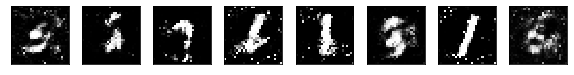

[Step 16000] D Loss: 0.5936; G Loss: 1.2792


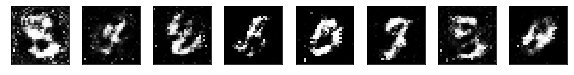

[Step 16500] D Loss: 0.5566; G Loss: 0.8418


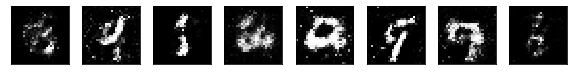

[Step 17000] D Loss: 0.6548; G Loss: 1.4283


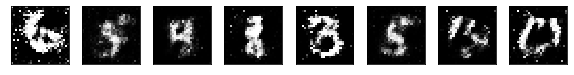

[Step 17500] D Loss: 0.5982; G Loss: 1.5143


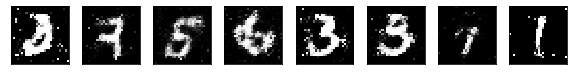

[Step 18000] D Loss: 0.4954; G Loss: 1.2648


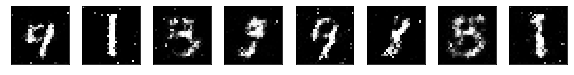

[Step 18500] D Loss: 0.6315; G Loss: 1.1060


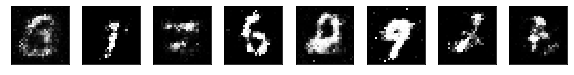

In [0]:
for step, true_images in enumerate(train_ds):
    # Цикл по батчам обучающего датасета (train_ds)
    # step — номер шага (батча), true_images — реальные изображения из датасета

    # === Обучение дискриминатора ===

    # Преобразуем true_images из тензора TensorFlow в numpy и reshape в 4D
    true_images = true_images.numpy().reshape((-1, 28, 28, 1))

    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    syntetic_images = generator.predict(noise)
    syntetic_images = syntetic_images.reshape((-1, 28, 28, 1))

    x_combined = np.concatenate((
        true_images,
        syntetic_images))
    # Объединяем реальные и сгенерированные изображения в один батч размером 32

    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1), np.float32),  # Метки "1" для реальных изображений
        np.zeros((HALF_BATCH_SIZE, 1), np.float32)))  # Метки "0" для фейковых изображений

    with tf.GradientTape() as tape:
        logits = discriminator(x_combined)
        # Пропускаем объединенный батч через дискриминатор (выходы — "логиты")

        d_loss_value = sigmoid_cross_entropy(y_combined, logits)
        # Считаем ошибку дискриминатора — насколько хорошо он отличил реальные и фейковые изображения

    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    # Вычисляем градиенты ошибки по параметрам дискриминатора

    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    # Применяем обновления к весам дискриминатора с помощью оптимизатора

    # === Обучение генератора ===

    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    # Создаем шум размером 32, чтобы сгенерировать 32 изображения

    y_mislabled = np.ones((BATCH_SIZE, 1), np.float32)
    # Метки "1" — при обучении генератора мы хотим, чтобы дискриминатор считал сгенерированные изображения настоящими

    with tf.GradientTape() as tape:
        syntetic = generator(noise, training=True)
        syntetic = tf.reshape(syntetic, (-1, 28, 28, 1))  # преобразуем форму
        logits = discriminator(syntetic, training=False)
        # Генерируем изображения из шума и сразу пропускаем через дискриминатор

        g_loss_value = sigmoid_cross_entropy(y_mislabled, logits)
        # Считаем ошибку генератора: как сильно дискриминатор ошибается и принимает фейк за реальное

    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    # Вычисляем градиенты ошибки по параметрам генератора

    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    # Обновляем веса генератора

    # === Отладка и визуализация промежуточных результатов ===

    if step % 500 == 0:
        # Каждые 500 шагов выводим текущие ошибки
        print('[Step %2d] D Loss: %.4f; G Loss: %.4f' % (
            step, d_loss_value.numpy(), g_loss_value.numpy()))

        noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
        # Создаем шум для генерации 8 изображений

        syntetic_images = generator.predict(noise)
        # Генерируем изображения

        plot_digits(syntetic_images)
        # Показываем сгенерированные изображения, чтобы визуально оценить прогресс обучения


## Тестирование генератора

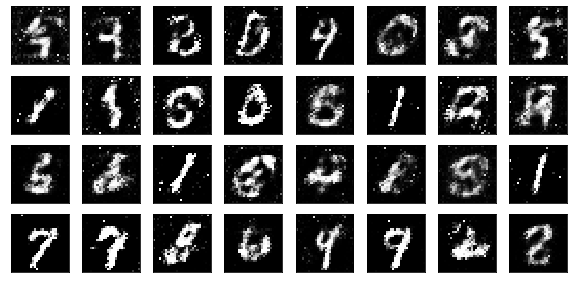

In [0]:
noise = np.random.normal(0, 1, (32, INPUT_DIM)).astype(np.float32)
# Создаем массив из 32 векторов случайного шума размером INPUT_DIM (100),
# где значения выбираются из нормального распределения с средним 0 и стандартным отклонением 1.
# .astype(np.float32) приводит тип данных к 32-битному числу с плавающей точкой, что требуется для TensorFlow.

syntetic_images = generator.predict(noise)
# Передаем шум на вход генератору, который создает 32 "фейковых" изображения.
# Результат — массив размером (32, 784) с пиксельными значениями в диапазоне [-1, 1].

plot_digits(syntetic_images)
# Визуализируем сгенерированные изображения функцией plot_digits.
# Каждый из 32 примеров будет показан в сетке 8x8,
# при этом в plot_digits изображения преобразуются обратно в форму 28x28 пикселей.

## Интерполяция в латентном пространстве

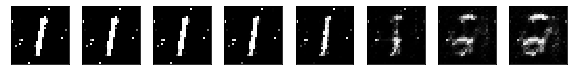

In [0]:
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
# Создаем первый вектор шума длиной INPUT_DIM (100), значения — из нормального распределения

noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
# Создаем второй вектор шума такого же размера и распределения

noise = np.linspace(noise_1, noise_2, 8)
# Генерируем 8 равномерно интерполированных векторов между noise_1 и noise_2
# np.linspace здесь создает матрицу (8, 100), где каждая строка — это точка на "линиинйной" траектории между двумя шумами
# Это позволяет плавно "промежуточно" менять вход генератора, чтобы увидеть переход от одного образа к другому

syntetic_images = generator.predict(noise)
# Генерируем 8 изображений по этим промежуточным векторам шума

plot_digits(syntetic_images)
# Показываем эти 8 сгенерированных изображений для визуализации плавного перехода между двумя "образами"

## Deep Convolutional GAN (DCGAN)

In [0]:
# Создаем генератор — сверточную нейросеть, которая генерирует изображения размером 28x28x1 (черно-белые)

generator = tf.keras.Sequential([
    tf.keras.layers.Dense(128*7*7, activation='relu'),
    # Полносвязный слой, который увеличивает размерность до 128*7*7=6272 признаков
    # Активация ReLU — стандартная функция активации, добавляющая нелинейность

    tf.keras.layers.Reshape((7, 7, 128)),
    # Преобразуем вектор признаков в 3D-тензор размером 7x7 с 128 каналами (признаками)

    tf.keras.layers.UpSampling2D((2, 2)),
    # Увеличиваем пространственное разрешение в два раза — с 7x7 до 14x14 (просто дублирование пикселей)

    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    # Сверточный слой с 128 фильтрами размером 3x3, padding='same' — выход того же размера 14x14

    tf.keras.layers.BatchNormalization(momentum=0.8),
    # Нормализация для ускорения и стабилизации обучения

    tf.keras.layers.ReLU(),
    # Активация ReLU

    tf.keras.layers.UpSampling2D((2, 2)),
    # Еще раз увеличиваем разрешение в 2 раза — теперь с 14x14 до 28x28

    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    # Сверточный слой с 64 фильтрами, размером 3x3, padding='same'

    tf.keras.layers.BatchNormalization(momentum=0.8),
    # Нормализация

    tf.keras.layers.ReLU(),
    # ReLU

    tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='tanh'),
    # Последний сверточный слой с 1 фильтром (т.к. изображение черно-белое)
    # Активация tanh для выхода значений пикселей в диапазоне [-1, 1]
])

# Создаем дискриминатор — сверточную сеть для классификации изображений как "реальные" или "фейковые"

discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same'),
    # Сверточный слой с 32 фильтрами 3x3, stride=2 для уменьшения размерности в 2 раза (downsampling)
    # padding='same' — сохраняет пространственные размеры, добавляя нули по краям

    tf.keras.layers.LeakyReLU(0.2),
    # LeakyReLU активация с отрицательным наклоном 0.2

    tf.keras.layers.Dropout(0.25),
    # Слой Dropout с вероятностью 0.25 — для регуляризации и предотвращения переобучения

    tf.keras.layers.Conv2D(64, kernel_size=3, strides=(2, 2), padding='same'),
    # Еще один сверточный слой с 64 фильтрами, stride=2 — еще уменьшение размерности

    tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1))),
    # Добавляем нулевое заполнение справа и снизу (1 пиксель), чтобы выровнять размерность перед следующим слоем

    tf.keras.layers.BatchNormalization(momentum=0.8),
    # Нормализация

    tf.keras.layers.LeakyReLU(alpha=0.2),
    # LeakyReLU

    tf.keras.layers.Dropout(0.25),
    # Dropout

    tf.keras.layers.Conv2D(128, kernel_size=3, strides=(2, 2), padding='same'),
    # Сверточный слой с 128 фильтрами, stride=2 — продолжаем уменьшать размерность

    tf.keras.layers.BatchNormalization(momentum=0.8),
    # Нормализация

    tf.keras.layers.LeakyReLU(alpha=0.2),
    # LeakyReLU

    tf.keras.layers.Dropout(0.25),
    # Dropout

    tf.keras.layers.Conv2D(256, kernel_size=3, strides=(1, 1), padding='same'),
    # Сверточный слой с 256 фильтрами, stride=1 — сохраняем размерность

    tf.keras.layers.BatchNormalization(momentum=0.8),
    # Нормализация

    tf.keras.layers.LeakyReLU(alpha=0.2),
    # LeakyReLU

    tf.keras.layers.Dropout(0.25),
    # Dropout

    tf.keras.layers.Flatten(),
    # Преобразуем 3D-тензор признаков в 1D вектор для передачи в Dense слой

    tf.keras.layers.Dense(1),
    # Выходной Dense слой с 1 нейроном — предсказывает "реальность" изображения (будет интерпретироваться как логит)
])

In [0]:
INPUT_DIM = 100
# Размер входного вектора шума для генератора — 100 случайных чисел

NUM_EPOCHS = 2
# Количество эпох — сколько раз пройдем по всему обучающему датасету

HALF_BATCH_SIZE = 16
# Половина размера батча — для тренировки дискриминатора на реальных и сгенерированных изображениях отдельно

BATCH_SIZE = HALF_BATCH_SIZE * 2
# Полный размер батча (32) — количество изображений, обрабатываемых за один шаг обучения

LEARNING_RATE = 0.0002
# Скорость обучения для оптимизатора Adam

# Создаем TensorFlow Dataset из массива train_x, предварительно меняем форму данных на 4D тензор:
# (-1 — число примеров, 28x28 — размеры изображения, 1 — количество каналов (ч/б изображение))
train_ds = tf.data.Dataset.from_tensor_slices(train_x.reshape(-1, 28, 28, 1))

# Перемешиваем датасет с размером буфера равным количеству примеров (полное перемешивание)
train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])

# Повторяем датасет заданное количество эпох (2 раза)
train_ds = train_ds.repeat(NUM_EPOCHS)

# Разбиваем датасет на батчи по 16 изображений, drop_remainder=True — отбросить последний неполный батч
train_ds = train_ds.batch(HALF_BATCH_SIZE, drop_remainder=True)

# Создаем оптимизатор Adam с указанной скоростью обучения
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

# Функция потерь — бинарная кросс-энтропия с логитами
sigmoid_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# from_logits=True означает, что входные данные для функции потерь еще не применили сигмоиду,
# функция сама добавит эту операцию при вычислении ошибки

[Step  0] D Loss: 0.8171; G Loss: 0.7017


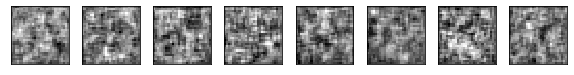

[Step 200] D Loss: 0.4245; G Loss: 2.8692


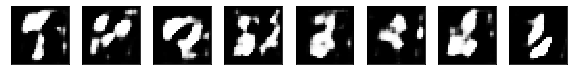

[Step 400] D Loss: 1.1851; G Loss: 0.9592


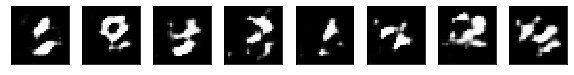

[Step 600] D Loss: 0.5472; G Loss: 1.8438


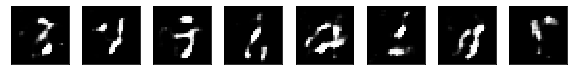

[Step 800] D Loss: 0.7522; G Loss: 1.0014


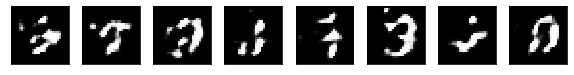

[Step 1000] D Loss: 0.5900; G Loss: 0.9983


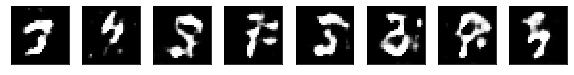

[Step 1200] D Loss: 0.6542; G Loss: 1.2866


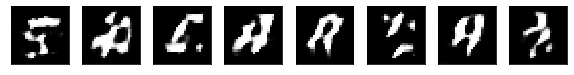

[Step 1400] D Loss: 0.5441; G Loss: 1.1970


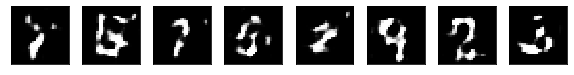

[Step 1600] D Loss: 0.7024; G Loss: 1.0025


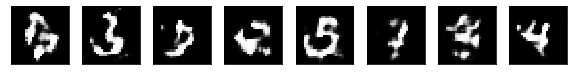

[Step 1800] D Loss: 0.6720; G Loss: 1.3497


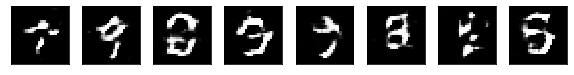

[Step 2000] D Loss: 0.6657; G Loss: 1.4607


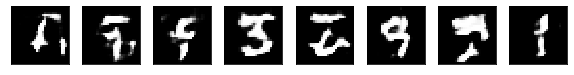

[Step 2200] D Loss: 0.7840; G Loss: 0.8791


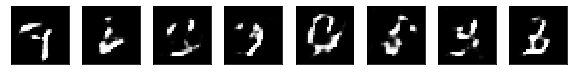

[Step 2400] D Loss: 0.6687; G Loss: 1.0813


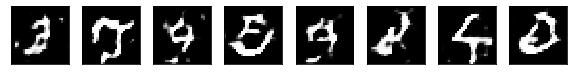

[Step 2600] D Loss: 0.6377; G Loss: 1.0218


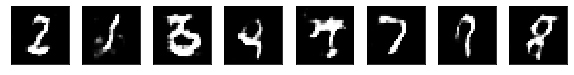

[Step 2800] D Loss: 0.5408; G Loss: 1.2987


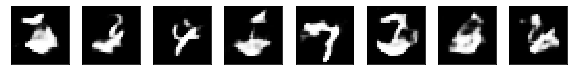

[Step 3000] D Loss: 0.5826; G Loss: 0.7747


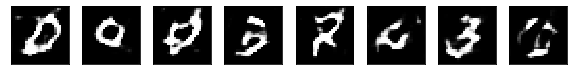

[Step 3200] D Loss: 0.6046; G Loss: 1.2247


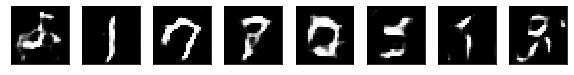

[Step 3400] D Loss: 0.6166; G Loss: 0.9074


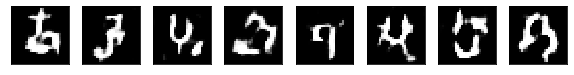

[Step 3600] D Loss: 0.7173; G Loss: 0.8473


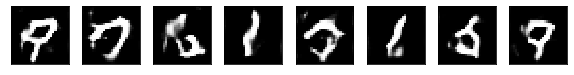

[Step 3800] D Loss: 0.6460; G Loss: 0.8922


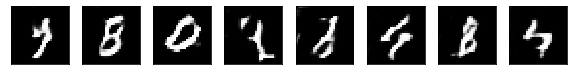

[Step 4000] D Loss: 0.7606; G Loss: 0.9356


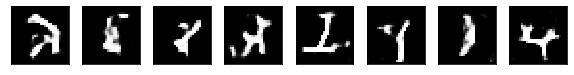

[Step 4200] D Loss: 0.8397; G Loss: 0.9671


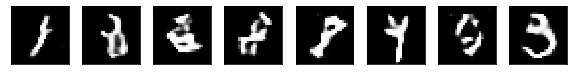

[Step 4400] D Loss: 0.7560; G Loss: 0.9462


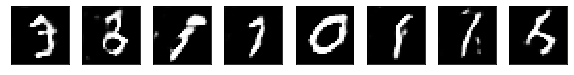

[Step 4600] D Loss: 0.6691; G Loss: 0.9061


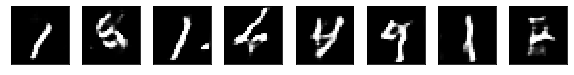

[Step 4800] D Loss: 0.5213; G Loss: 1.0011


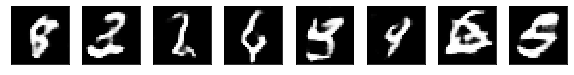

[Step 5000] D Loss: 0.6925; G Loss: 0.7535


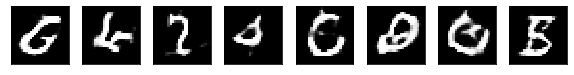

[Step 5200] D Loss: 0.8152; G Loss: 0.6278


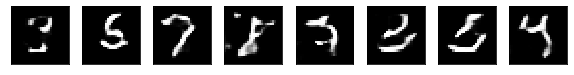

[Step 5400] D Loss: 0.6226; G Loss: 0.8183


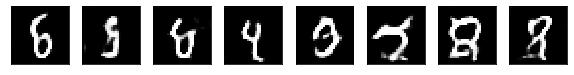

[Step 5600] D Loss: 0.7497; G Loss: 0.8760


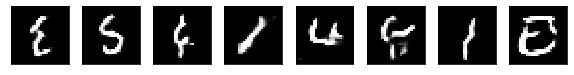

[Step 5800] D Loss: 0.7530; G Loss: 0.9151


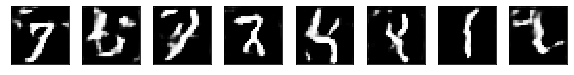

[Step 6000] D Loss: 0.7047; G Loss: 0.9899


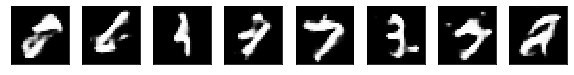

[Step 6200] D Loss: 0.7940; G Loss: 0.9090


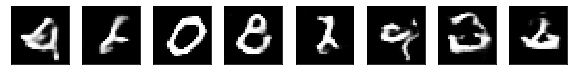

[Step 6400] D Loss: 0.6350; G Loss: 1.0084


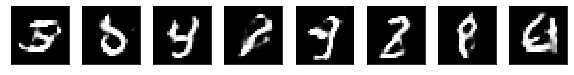

[Step 6600] D Loss: 0.5693; G Loss: 0.9464


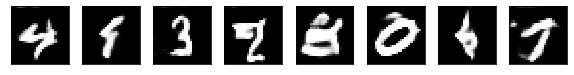

[Step 6800] D Loss: 0.6290; G Loss: 0.8067


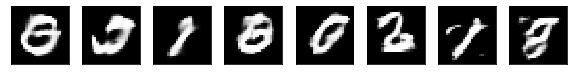

[Step 7000] D Loss: 0.6719; G Loss: 0.7303


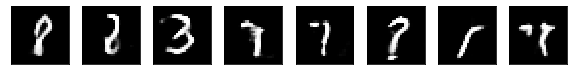

[Step 7200] D Loss: 0.5871; G Loss: 1.0510


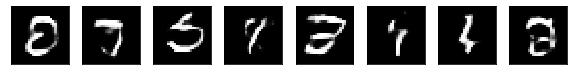

[Step 7400] D Loss: 0.5659; G Loss: 1.1327


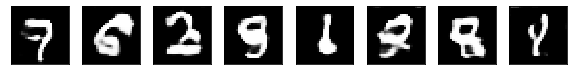

In [0]:
for step, true_images in enumerate(train_ds):
    # Итерация по батчам обучающего датасета train_ds
    # step — номер шага (батча), true_images — батч реальных изображений (16 штук)

    # === Обучение дискриминатора ===

    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    # Создаем случайный шум (16 векторов по 100 элементов) для генератора

    syntetic_images = generator.predict(noise)
    # Генерируем "фейковые" изображения из шума

    x_combined = np.concatenate((
        true_images,  # реальные изображения из датасета
        syntetic_images))  # сгенерированные изображения
    # Объединяем реальные и фейковые изображения в один батч (32 изображения)

    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1), np.float32),  # метки 1 для реальных изображений
        np.zeros((HALF_BATCH_SIZE, 1), np.float32)))  # метки 0 для фейковых

    with tf.GradientTape() as tape:
        logits = discriminator(x_combined, training=True)
        # Передаем батч в дискриминатор (в режиме обучения)
        # logits — необработанные выходы (логиты) сети

        d_loss_value = sigmoid_cross_entropy(y_combined, logits)
        # Вычисляем потерю дискриминатора — насколько хорошо он отличил реальные и сгенерированные изображения

    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    # Вычисляем градиенты ошибки по параметрам дискриминатора

    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    # Обновляем веса дискриминатора с помощью оптимизатора Adam

    # === Обучение генератора ===

    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    # Создаем шум для генератора (32 вектора по 100 элементов)

    y_mislabled = np.ones((BATCH_SIZE, 1), np.float32)
    # Метки "1" — хотим, чтобы дискриминатор принимал сгенерированные изображения за настоящие

    with tf.GradientTape() as tape:
        syntetic = generator(noise, training=True)
        # Генерируем изображения с генератора в режиме обучения

        logits = discriminator(syntetic, training=False)
        # Пропускаем сгенерированные изображения через дискриминатор (режим инференса — без обновления его параметров)

        g_loss_value = sigmoid_cross_entropy(y_mislabled, logits)
        # Вычисляем потерю генератора — насколько хорошо он "обманывает" дискриминатор

    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    # Вычисляем градиенты ошибки генератора

    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    # Обновляем веса генератора

    # === Визуализация и контроль ===

    if step % 200 == 0:
        # Каждые 200 шагов выводим текущие значения потерь
        print('[Step %2d] D Loss: %.4f; G Loss: %.4f' % (
            step, d_loss_value.numpy(), g_loss_value.numpy()))

        noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
        # Создаем шум для генерации 8 изображений

        syntetic_images = generator.predict(noise)
        # Генерируем изображения

        plot_digits(syntetic_images)
        # Визуализируем сгенерированные изображения, чтобы оценить качество генерации




## Тестирование свёрточного генератора

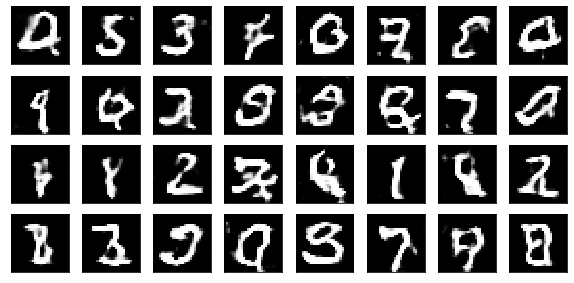

In [0]:
noise = np.random.normal(0, 1, (32, INPUT_DIM)).astype(np.float32)
# Создаем массив из 32 векторов шума размером INPUT_DIM (100), значения из нормального распределения (среднее=0, std=1)
# Приводим тип к float32, что требуется для работы с TensorFlow

syntetic_images = generator.predict(noise)
# Передаем шум на вход генератора, который создаст 32 изображения размером 28x28x1 с пикселями в диапазоне [-1, 1]

plot_digits(syntetic_images)
# Отображаем сгенерированные изображения в сетке с помощью функции plot_digits
# Функция преобразует каждый вектор обратно в 28x28 и показывает как черно-белые картинки

## Интерполяция в латентном пространстве

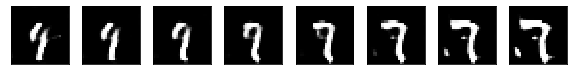

In [0]:
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
# Создаем первый вектор шума длиной INPUT_DIM (100) с нормальным распределением

noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
# Создаем второй вектор шума такого же размера и распределения

noise = np.linspace(noise_1, noise_2, 8)
# Создаем 8 равномерно интерполированных векторов между noise_1 и noise_2
# np.linspace создает матрицу (8, 100), где каждая строка — точка между двумя шумами
# Это позволяет плавно менять вход генератора, чтобы увидеть переход между образами

syntetic_images = generator.predict(noise)
# Генерируем 8 изображений по этим промежуточным векторам шума

plot_digits(syntetic_images)
# Показываем эти 8 сгенерированных изображений для визуализации плавного перехода между двумя "образами"
